In [1]:
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import Activation
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model

#If you are using Tensorflow 1.x
from keras.optimizers import Adam
#If you are using Tensorflow 2
#from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt

import numpy as np

import os

from PIL import Image

Using TensorFlow backend.


# Parameters

In [2]:
#folder containing dataset
data_path = r'D:\Downloads\selfie2anime\trainB'

#how many epochs to run the model
epoch = 10

#how many epochs between saving your model
interval = 2

#how many images to train at one time. If batch size is less than 9, alter the save_img function to plot less images
batch = 10

#if the data has pngs set this to True to remove alpha layer from images
png = False

# Load dataset from local files

In [3]:
def load_data():
        data = []
        small = []
        paths = []
        #get all files in this folder
        for r, d, f in os.walk(data_path):
            for file in f:
                if '.jpg' in file or 'png' in file:
                    paths.append(os.path.join(r, file))
        #for each file add normal resolution and low resolution to arrays
        for path in paths:
            img = Image.open(path)
            x = np.array(img.resize((64,64)))
            y = np.array(img.resize((128,128)))
            if(png):
                x = x[...,:3]
            data.append(y)
            small.append(x)
            
        #reshaping data to be four dimension required for input to neural network
        y_train = np.array(data)
        y_train = y_train.reshape(len(data),128,128,3)
        x_train = np.array(small)
        x_train = x_train.reshape(len(small),64,64,3)
        del data
        del small
        del paths
        return y_train, x_train

In [4]:
class SRGAN():
    def __init__(self):
        
        # Shape of high resolution output image
        self.img_rows = 128
        self.img_cols = 128
        self.channels = 3
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        
        # Shape of low resolution input image
        self.latent_dim = (64,64,3)

        #optimizer (learning rate and beta values)
        optimizer = Adam(0.0001, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()
        generator = self.generator

        # The generator takes noise as input and generates imgs
        z = Input(shape=self.latent_dim)
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        valid = self.discriminator(img)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, valid)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)

    def build_generator(self):

        model = Sequential()
        model.add(Conv2D(128, input_shape=self.latent_dim, kernel_size=(3,3), padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Conv2D(128, kernel_size=(3,3), padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(UpSampling2D())
        model.add(Conv2D(128, kernel_size=(3,3), padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Conv2D(128, kernel_size=(3,3), padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Conv2D(128, kernel_size=(3,3), padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Conv2D(3, kernel_size=(3,3), padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.summary()

        noise = Input(shape=self.latent_dim)
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):

        model = Sequential()

        model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=self.img_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(128, kernel_size=3, strides=1, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Flatten())
        model.add(Dense(1, activation='sigmoid'))

        model.summary()

        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)
    

    def train(self, epochs, batch_size=128, save_interval=50):

        # Load the dataset
        Y_train, X_train = load_data()

        # Rescale to be between 0 & 1
        X_train = X_train / 255
        Y_train = Y_train / 255

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))
        
        # Placeholder for loss function values
        g_loss_epochs = np.zeros((epochs, 1))
        d_loss_epochs = np.zeros((epochs, 1))

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random batch of images
            idx = np.random.randint(0, Y_train.shape[0], batch_size)
            imgs = Y_train[idx]

            # Generate super resolution images from the random batch of images
            gen_imgs = self.generator.predict(X_train[idx])

            # Train the discriminator (real classified as ones and generated as zeros)
            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

            # Train the generator (wants discriminator to mistake images as real)
            g_loss = self.combined.train_on_batch(X_train[idx], valid)
            
            #save loss history
            g_loss_epochs[epoch] = g_loss
            d_loss_epochs[epoch] = d_loss[0]

            # Plot the progress
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

            # If at save interval => save generated image samples
            if epoch % save_interval == 0:
                self.save_imgs(epoch, X_train, idx)
                
        return g_loss_epochs, d_loss_epochs

    def save_imgs(self, epoch, X_train, idx):
        r, c = 3, 3
        # Select 9 random images
        index = np.random.randint(0, X_train.shape[0], 9)
        images = X_train[idx]
        # Super resolution the images
        gen_imgs = self.generator.predict(images)
        gen_imgs = np.array(gen_imgs) * 255
        gen_imgs = gen_imgs.astype(int)
        # Plot each image
        fig=plt.figure(figsize=(20, 20))
        for i in range(1, c*r+1):
            img = gen_imgs[i-1]
            fig.add_subplot(r, c, i)
            plt.imshow(img)
        fig.savefig(r"C:\Users\Vee\Desktop\python\GAN\epoch_%d.png" % epoch)
        plt.close()
        # save model to .h5 file
        self.generator.save(r"C:\Users\Vee\Desktop\python\GAN\models\generator" + str(epoch) + ".h5")

# Create Model and View Summary

In [5]:
gan = SRGAN()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 64, 32)        896       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 64, 64, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 32, 32, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 128)      

# Train Model

In [6]:
g_loss, d_loss = gan.train(epochs=epoch, batch_size=batch, save_interval=interval)

C:\Users\Vee\Anaconda3\lib\site-packages\keras\engine\training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
C:\Users\Vee\Anaconda3\lib\site-packages\keras\engine\training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0

0 [D loss: 0.696746, acc.: 20.00%] [G loss: 0.691277]


C:\Users\Vee\Anaconda3\lib\site-packages\keras\engine\training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1 [D loss: 0.646467, acc.: 50.00%] [G loss: 0.679452]
2 [D loss: 0.606416, acc.: 50.00%] [G loss: 0.642626]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3 [D loss: 0.613520, acc.: 50.00%] [G loss: 0.586475]
4 [D loss: 0.663365, acc.: 50.00%] [G loss: 0.510259]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


5 [D loss: 0.772491, acc.: 50.00%] [G loss: 0.456915]
6 [D loss: 0.835647, acc.: 50.00%] [G loss: 0.457943]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


7 [D loss: 0.753171, acc.: 50.00%] [G loss: 0.657442]
8 [D loss: 0.702175, acc.: 55.00%] [G loss: 1.004203]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


9 [D loss: 0.620197, acc.: 95.00%] [G loss: 1.414992]


# Plot Loss

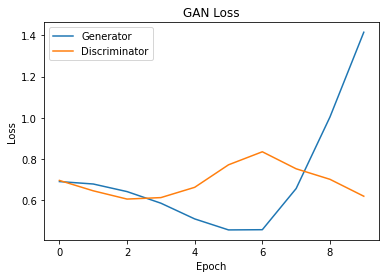

In [7]:
plt.plot(g_loss)
plt.plot(d_loss)
plt.title('GAN Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Generator', 'Discriminator'], loc='upper left')
plt.show()